<a href="https://www.kaggle.com/code/jamesdavey/100x-faster-pixel-coordinate-generator-1s-runtime?scriptVersionId=122518549" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Pixel coordinate generation

In this notebook, I have rewritten the process for getting pixels coordinates described in the [Tutorial notebook](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial) 

The aim of it is to assist the process of dataset creation described in that notebook, and to rapidly speed it up.

The original way took ~70 seconds, my way speeds this up by eliminating the need for a loop, allowing it to run in ~3 seconds. Over 20x faster :)

At the bottom of the notebook I verify both ways produce identical outputs so we can be sure it is working correctly.

In [1]:
import torch
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import os
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"on device: {device}")

BUFFER = 30 # ie. each square into network is 30*2+1=61 wide
rect = (1100, 3500, 700, 950) # (x, y, w, h)

on device: cpu


In [2]:
root_filepath = '/kaggle/input/vesuvius-challenge-ink-detection/train/1/'
#['inklabels.png', 'inklabels_rle.csv', 'ir.png', 'mask.png', 'surface_volume']
tif_filenames = sorted(os.listdir(root_filepath+'surface_volume'))
print(len(tif_filenames), tif_filenames[:5])

mask = torch.from_numpy(np.array(PIL.Image.open(root_filepath+"mask.png").convert('1')))
label = torch.from_numpy(np.array(PIL.Image.open(root_filepath+"inklabels.png"))).float().to(device)

65 ['00.tif', '01.tif', '02.tif', '03.tif', '04.tif']


The functions below produce all pixel coordinates for pixels within the rectangle and outside it. (Note: In both coordinates are restricted to the mask)

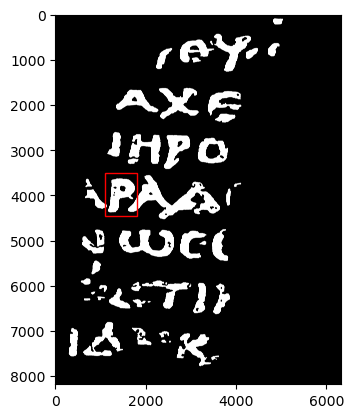

In [3]:
fig, ax = plt.subplots()
ax.imshow(label.cpu(), cmap = 'gray')
patch1 = matplotlib.patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(patch1)
plt.show()

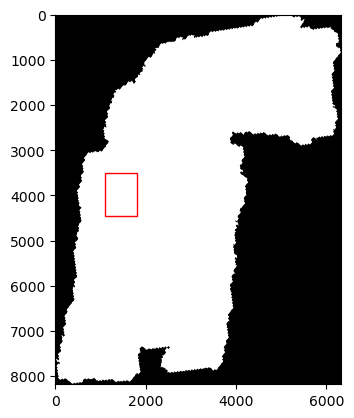

In [4]:
fig, ax = plt.subplots()
ax.imshow(mask, cmap = 'gray')
patch1 = matplotlib.patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(patch1)
plt.show()

In [5]:
%%time
# Takes in a mask, and outputs the set of pixels (x,y) in intersection of that mask with a rectangle
# Also outputs the set intersection of that mask with the exterior of the rectangle

def get_pixels():
    max_h,max_w = mask.shape # Height and width of mask
    x, y, w, h = rect
    
    # Create a Boolean array of the same shape as the bitmask, initially all True
    not_border = np.zeros(mask.shape, dtype=bool)
    not_border[BUFFER:max_h-BUFFER, BUFFER:max_w-BUFFER] = True
    arr_mask = np.array(mask) * not_border
    
    inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
    # Sets all indexes with inside_rect array to true
    inside_rect[y:y+h+1, x:x+w+1] = True
    
    outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
    # Set the pixels within the inside_rect to False
    outside_rect[y:y+h+1, x:x+w+1] = False
    
    return np.argwhere(inside_rect), np.argwhere(outside_rect)
    
pixels_inside_rect2, pixels_outside_rect2 = get_pixels()

CPU times: user 626 ms, sys: 409 ms, total: 1.03 s
Wall time: 1.03 s


In [6]:
%%time
print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the 
# val set, and the pixels outside the rect are the train set.
pixels_inside_rect = []
pixels_outside_rect = []
for pixel in zip(*np.where(mask == 1)):
    if pixel[1] < BUFFER or pixel[1] >= mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask.shape[0]-BUFFER:
        continue # Too close to the edge
    if pixel[1] >= rect[0] and pixel[1] <= rect[0]+rect[2] and pixel[0] >= rect[1] and pixel[0] <= rect[1]+rect[3]:
        pixels_inside_rect.append(pixel)
    else:
        pixels_outside_rect.append(pixel)

print(f"pixels_inside_rect: {len(pixels_inside_rect)} | pixels_outside_rect: {len(pixels_outside_rect)}")

Generating pixel lists...
pixels_inside_rect: 666651 | pixels_outside_rect: 28470276
CPU times: user 1min 5s, sys: 4.57 s, total: 1min 9s
Wall time: 1min 9s


In [7]:
pixels_inside_rect2, np.array(pixels_inside_rect)

(array([[3500, 1100],
        [3500, 1101],
        [3500, 1102],
        ...,
        [4450, 1798],
        [4450, 1799],
        [4450, 1800]]),
 array([[3500, 1100],
        [3500, 1101],
        [3500, 1102],
        ...,
        [4450, 1798],
        [4450, 1799],
        [4450, 1800]]))

In [8]:
#Pixel coordinates match up perfectly :)

print((np.array(pixels_inside_rect) == pixels_inside_rect2).min())
print((np.array(pixels_outside_rect) == pixels_outside_rect2).min())

True
True
